In [2]:
import shioaji as sj
import pysimulation

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="",
    secret_key=""
)

2023-03-18 21:03:27.715 | WARNING  | importlib._bootstrap:_call_with_frames_removed:219 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [3]:
import datetime
import pandas as pd
from backtesting.lib import OHLCV_AGG

days = 366

# last_days = datetime.datetime.now() - datetime.timedelta(days=days)
last_days = datetime.datetime(2022, 3, 13)

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=last_days.strftime("%Y-%m-%d"), 
    end=last_days.strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

for i in range(days-1):
    date = last_days + datetime.timedelta(days=i+1)
    print(date.strftime("%Y-%m-%d"))
    kbars = api.kbars(
        contract=api.Contracts.Futures.TXF.TXFR1, 
        start=date.strftime("%Y-%m-%d"), 
        end=date.strftime("%Y-%m-%d"),
    )
    if kbars['ts'] != []:
        df = pd.DataFrame({**kbars})
        df.ts = pd.to_datetime(df.ts)
        df = df.set_index('ts')
        df.index.name = None
        df_1min = pd.concat([df_1min, df], axis=0)

df_1min = df_1min.between_time('08:45:00', '13:45:01')
df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

'''
df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('5T', label='right').agg(OHLCV_AGG).dropna()
'''

2022-03-14
2022-03-15
2022-03-16
2022-03-17
2022-03-18
2022-03-19
2022-03-20
2022-03-21
2022-03-22
2022-03-23
2022-03-24
2022-03-25
2022-03-26
2022-03-27
2022-03-28
2022-03-29
2022-03-30
2022-03-31
2022-04-01
2022-04-02
2022-04-03
2022-04-04
2022-04-05
2022-04-06
2022-04-07
2022-04-08
2022-04-09
2022-04-10
2022-04-11
2022-04-12
2022-04-13
2022-04-14
2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
2022-05-01
2022-05-02
2022-05-03
2022-05-04
2022-05-05
2022-05-06
2022-05-07
2022-05-08
2022-05-09
2022-05-10
2022-05-11
2022-05-12
2022-05-13
2022-05-14
2022-05-15
2022-05-16
2022-05-17
2022-05-18
2022-05-19
2022-05-20
2022-05-21
2022-05-22
2022-05-23
2022-05-24
2022-05-25
2022-05-26
2022-05-27
2022-05-28
2022-05-29
2022-05-30
2022-05-31
2022-06-01
2022-06-02
2022-06-03
2022-06-04
2022-06-05
2022-06-06
2022-06-07
2022-06-08
2022-06-09
2022-06-10
2022-06-11
2022-06-12

'\ndf = pd.read_csv(f"TXF_1min.csv", index_col=0)\ndf.index = pd.to_datetime(df.index)\ndf = df.resample(\'5T\', label=\'right\').agg(OHLCV_AGG).dropna()\n'

In [1]:
import datetime
import pandas as pd
import os
from backtesting.lib import OHLCV_AGG

df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df.dropna(axis=0, inplace=True)

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta
from datetime import time


class myStrategy(Strategy): 
    lower_bound = 20 # oversold area
    higher_bound = 80 # overbought area
    half = 50
    kd_period = 7
    div = 4 # stoch slowd_period
    n1 = 9 # fast ema
    n2 = 32 # slow ema
    macd_period = 5

    def init(self):
        self.k, self.d = self.I(ta.STOCH, high=self.data.High, low=self.data.Low, close=self.data.Close, fastk_period=self.kd_period, slowk_period=self.div, slowd_period=self.div) # line K and D
        self.macd, self.macdsignal, self.macdhist = self.I(ta.MACD, self.data.Close, self.n1, self.n2, self.macd_period) # macd(fast), macd(slow), macd histogram

    def next(self):
        # operating time : 9:15~13:30, stop loss = 0.2%, take profit = 0.4%
        if (self.data.index[-1].time() < time(13, 25)) and (self.data.index[-1].time() > time(9, 15)):
            # In overbought area and any signal indicate down, close long order and sell
            if (self.k[-1] > self.higher_bound) and (self.d[-1] > self.higher_bound) and (crossover(self.d, self.k) or crossover(self.macdsignal, self.macd) or crossover(0, self.macdhist)) and self.position.is_long:
                self.position.close()
                self.sell(size=200, sl=self.data.Close[-1]*1.003, tp=self.data.Close[-1]*0.98)
            # In oversold area and any signal indicate up, close short order and buy
            elif (self.k[-1] < self.lower_bound) and (self.d[-1] < self.lower_bound) and (crossover(self.k, self.d) or crossover(self.macd, self.macdsignal) or crossover(self.macdhist, 0)) and self.position.is_short:
                self.position.close()
                self.buy(size=200, sl=self.data.Close[-1]*0.997, tp=self.data.Close[-1]*1.02)
            # k crossdown overbought, and any macd seems to be down, then close long order
            elif crossover(self.higher_bound, self.k) and (crossover(self.d, self.k) or crossover(self.macdsignal, self.macd) or crossover(0, self.macdhist)) and self.position.is_long:
                self.position.close()
            # k crossover oversold, and any macd seems to be up, then close long order
            elif crossover(self.k, self.lower_bound) and (crossover(self.k, self.d) or crossover(self.macd, self.macdsignal) or crossover(self.macdhist, 0)) and self.position.is_short:
                self.position.close()
            # In normal area, k crossover d and any macd signal indicate up, buy
            elif crossover(self.k, self.d) and (self.k[-1] < self.higher_bound) and ((self.macd > 0) or crossover(self.macd, self.macdsignal) or (self.macdhist > 0)):
                if(not self.position) and (self.k[-1] > self.half-14) and (self.d[-1] > self.half-12):
                    self.buy(size=200, sl=self.data.Close[-1]*0.997, tp=self.data.Close[-1]*1.015)
                elif (self.position.is_short) and (not self.position.is_long) and (self.k[-1] > self.half) and (self.d[-1] > self.half):
                    self.position.close()
                    self.buy(size=200, sl=self.data.Close[-1]*0.997, tp=self.data.Close[-1]*1.015)
            # In normal area, k crossdown d and any macd signal indicate down, sell
            elif crossover(self.d, self.k) and (self.k[-1] > self.lower_bound) and ((self.macd < 0) or crossover(self.macdsignal, self.macd) or (self.macdhist < 0)):
                if(not self.position) and (self.k[-1] < self.half+14) and (self.d[-1] < self.half+12):
                    self.sell(size=200, sl=self.data.Close[-1]*1.003, tp=self.data.Close[-1]*0.985)
                elif (self.position.is_long) and (not self.position.is_short) and (self.k[-1] < self.half) and (self.d[-1] < self.half):
                    self.position.close()
                    self.sell(size=200, sl=self.data.Close[-1]*1.003, tp=self.data.Close[-1]*0.985)
            # Any time, any indicator indicate other side, close position
            elif crossover(self.k, self.d) or crossover(self.macd, self.macdsignal) or crossover(self.macdhist, 0) and self.position.is_short:
                self.position.close()
            elif crossover(self.d, self.k) or crossover(self.macdsignal, self.macd) or crossover(0, self.macdhist) and self.position.is_long:
                self.position.close()
        # close position at 13:30
        elif (self.data.index[-1].time() >= time(13, 25)) and self.position:
            self.position.close()

In [3]:
from backtesting import Backtest

bt = Backtest(df, myStrategy, cash=500_000, commission=0.00003, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats.to_string())
bt.plot(resample=False)

Start                                                   2022-03-14 08:50:00
End                                                     2023-03-13 13:45:00
Duration                                                  364 days 04:55:00
Exposure Time [%]                                                 28.599727
Equity Final [$]                                                 740703.074
Equity Peak [$]                                                  748152.282
Return [%]                                                        48.140615
Buy & Hold Return [%]                                            -10.273458
Return (Ann.) [%]                                                 51.533684
Volatility (Ann.) [%]                                             37.194094
Sharpe Ratio                                                       1.385534
Sortino Ratio                                                      3.454783
Calmar Ratio                                                       3.347591
Max. Drawdow

Row(id='1598', ...)

In [42]:
from backtesting.lib import _EQUITY_AGG
stats._trades['ExitTime'].head(600)

0     2022-03-14 12:55:00
1     2022-03-15 13:15:00
2     2022-03-17 12:45:00
3     2022-03-18 09:55:00
4     2022-03-18 10:40:00
              ...        
595   2023-01-13 13:30:00
596   2023-01-16 10:20:00
597   2023-01-16 10:25:00
598   2023-01-16 13:30:00
599   2023-01-17 09:45:00
Name: ExitTime, Length: 600, dtype: datetime64[ns]

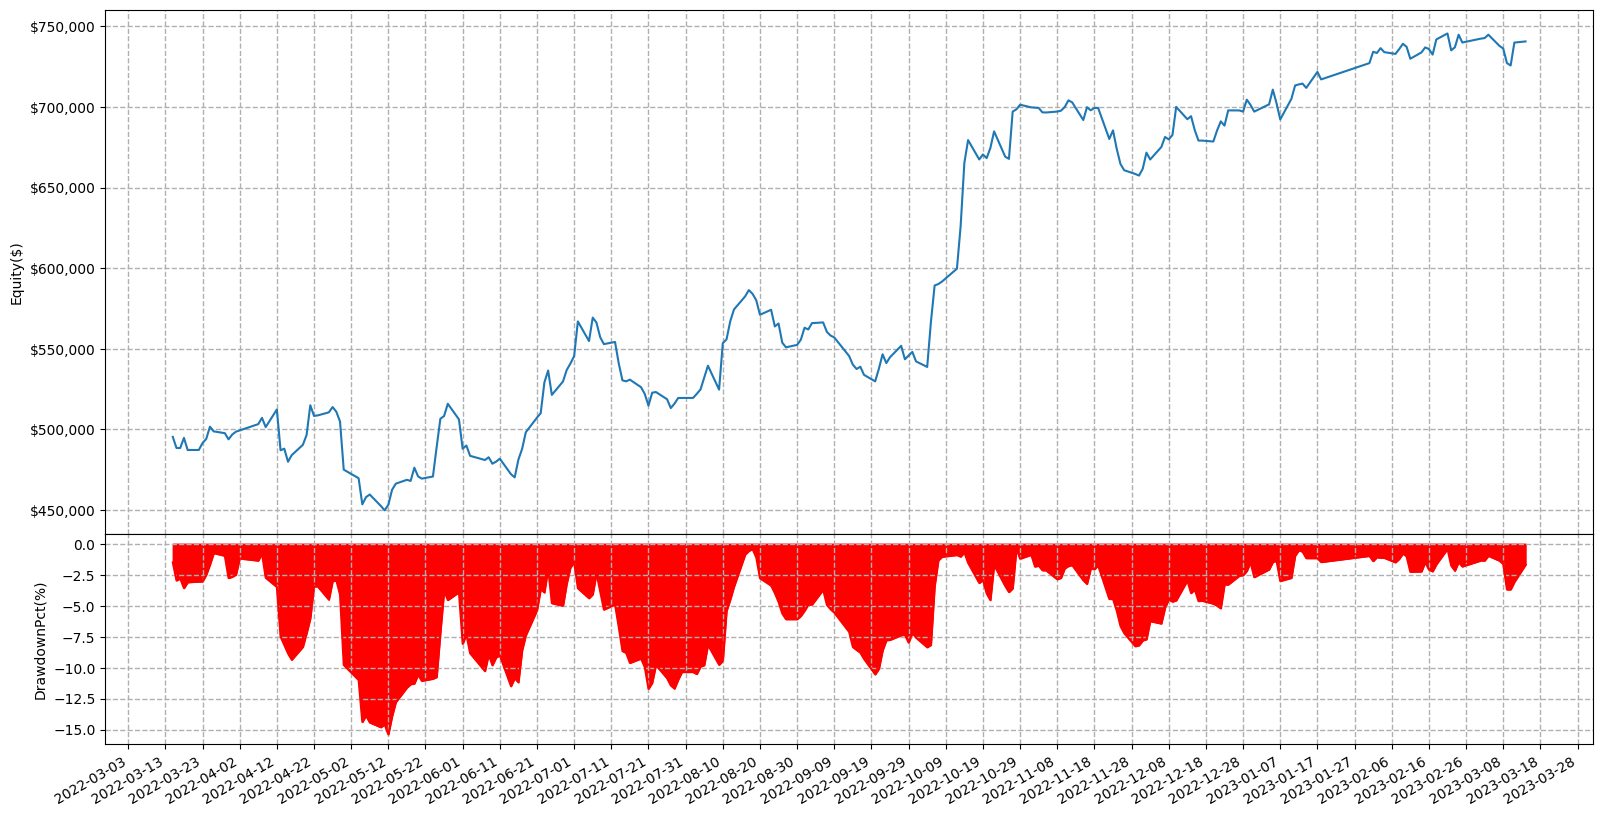

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

In [9]:
df_in_sample = df[df.index <= '2023-11-13']
bt = Backtest(df_in_sample, myStrategy, cash=500_000, commission=0.00003, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.optimize(kd_period=range(4, 24, 1),
                    div = range(3, 15, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.kd_period > p.div,
                    ) # 快線週期<慢線週期
print(stats.to_string())

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Start                                                   2022-03-14 08:50:00
End                                                     2023-03-13 13:45:00
Duration                                                  364 days 04:55:00
Exposure Time [%]                                                 28.558743
Equity Final [$]                                                  814054.33
Equity Peak [$]                                                  820147.486
Return [%]                                                        62.810866
Buy & Hold Return [%]                                            -10.273458
Return (Ann.) [%]                                                 63.244637
Volatility (Ann.) [%]                                             56.828349
Sharpe Ratio                                                       1.112906
Sortino Ratio                                                       4.70997
Calmar Ratio                                                       3.996654
Max. Drawdow

In [12]:
bt = Backtest(df_in_sample, myStrategy, cash=500_000, commission=0.00003, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.optimize(n1=range(8, 16, 1),
                    n2 = range(25, 35, 1),
                    macd_period=range(5, 15, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda p: p.macd_period < p.n1
                    ) # 快線週期<慢線週期
print(stats.to_string())

/Users/yen/.pyenv/versions/3.7.15/lib/python3.7/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 520 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/8 [00:00<?, ?it/s]

Start                                                   2022-03-14 08:50:00
End                                                     2023-03-13 13:45:00
Duration                                                  364 days 04:55:00
Exposure Time [%]                                                 29.310109
Equity Final [$]                                                 862931.294
Equity Peak [$]                                                  870780.502
Return [%]                                                        72.586259
Buy & Hold Return [%]                                            -10.273458
Return (Ann.) [%]                                                 77.425515
Volatility (Ann.) [%]                                             63.255351
Sharpe Ratio                                                       1.224015
Sortino Ratio                                                      5.515505
Calmar Ratio                                                       4.500743
Max. Drawdow